In [5]:
import numpy as np 
import keras_tuner as kt
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
def preprocess_data(data, labels):
    data = data / 255.0

    if len(data.shape) == 3:
        data = data.reshape(-1, data.shape[1], data.shape[2], 1)

    fractional_hours = (labels[:, 0]) + labels[:, 1] / 60.0

    labels_processed = fractional_hours / 12.0  # 12 hours on an analogue clock
    
    data_train, data_temp, labels_train, labels_temp = train_test_split(
        data, labels_processed, test_size=0.2, random_state=42, shuffle=True
    )
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42
    )
    return data_train, labels_train, data_test, labels_test, data_val, labels_val


def common_sense_metric(y_true, y_pred):
    y_true = y_true * 12.0
    y_pred = y_pred * 12.0

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12.0 - linear_diff)

    return tf.reduce_mean(circular_diff)


def common_sense_loss(y_true, y_pred):
    y_true = y_true * 12.0
    y_pred = y_pred * 12.0

    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12.0 - linear_diff)

    return tf.reduce_mean(tf.square(circular_diff))


def plot_training_validation_mae(history):
    train_mae = history.history['common_sense_metric']
    val_mae = history.history['val_common_sense_metric']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mea')
    plt.title('Training and validation mean absolute error')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_distribution(y_true, y_pred, num_bins=30):
    y_true = y_true * 12.0
    y_pred = y_pred * 12.0

    linear_diff = np.abs(y_true - y_pred)
    circular_error = np.minimum(linear_diff, 12.0 - linear_diff)

    plt.figure(figsize=(10, 6))
    plt.hist(circular_error, bins=num_bins, color='skyblue', edgecolor='black')
    plt.title('Distribution of Circular Errors on Test Set')
    plt.xlabel('Error (hours)')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

    # Statistics of the error distribution
    mean_error = np.mean(circular_error)
    median_error = np.median(circular_error)
    max_error = np.max(circular_error)

    print(f"Mean Error: {mean_error:.2f} hours")
    print(f"Median Error: {median_error:.2f} hours")
    print(f"Max Error: {max_error:.2f} hours")


/vol/home/s4484010/miniforge3/envs/IDL2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731354980.369869 4016893 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4799 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,049 (1.17 MB)

 Trainable params: 306,049 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1731354981.652699 4024253 service.cc:148] XLA service 0x7a7120002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731354981.652726 4024253 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-11 20:56:21.670628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731354981.759525 4024253 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-11 20:56:22.822728: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 59/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - common_sense_metric: 3.0711 - loss: 12.4100

I0000 00:00:1731354983.363953 4024253 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - common_sense_metric: 3.0271 - loss: 12.1862 - val_common_sense_metric: 2.7642 - val_loss: 12.2811
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.2423 - loss: 12.1399 - val_common_sense_metric: 3.0353 - val_loss: 12.1549
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.9928 - loss: 12.0806 - val_common_sense_metric: 3.0353 - val_loss: 12.1904
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.8442 - loss: 11.8463 - val_common_sense_metric: 2.9520 - val_loss: 12.0763
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.7945 - loss: 11.6062 - val_common_sense_metric: 2.9321 - val_loss: 10.9252
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - common_sense_metric: 2.6946 - loss: 10.2993 - val_common_sense_metric: 2.7449 - val_loss: 9.3433
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - common_sense_metric: 2.4507 - loss: 8.95

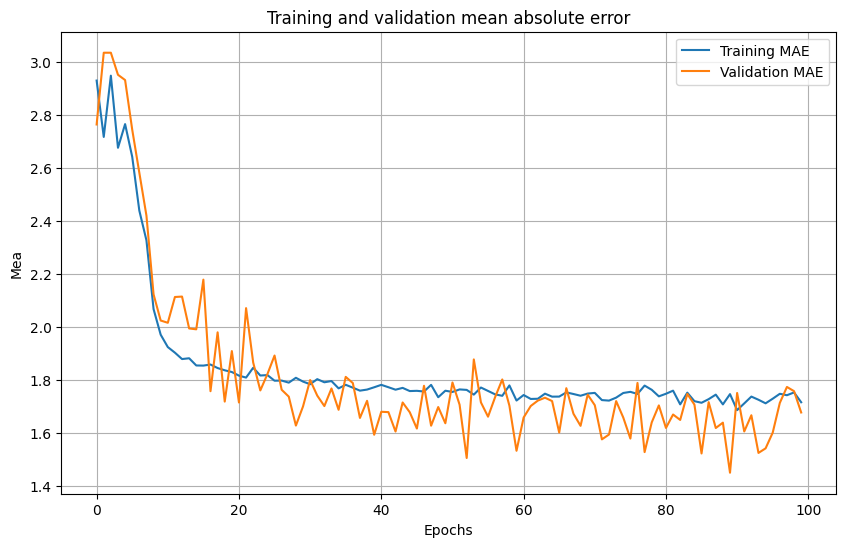

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: The 'color' keyword argument must have one color per dataset, but 1800 datasets and 1 colors were provided

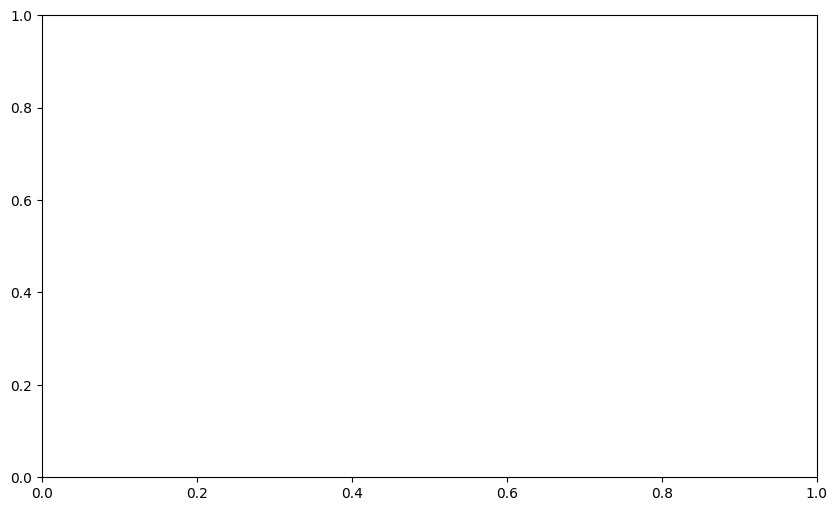

In [ ]:
def create_cnn(image_length, data, labels):    
    tf.keras.backend.clear_session()
    gc.collect()
    data_train, labels_train, data_test, labels_test, data_val, labels_val = preprocess_data(data, labels)

    # CNN for time components (regression)
    model = Sequential([
        # Layer 0
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_length, image_length, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        # Layer 1
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        # Layer 2
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        # Layer 3
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1) 
        
    ])

    optimizer = Adam(learning_rate=1e-4)
    
    model.summary() 

    model.compile(optimizer=optimizer, loss=common_sense_loss, metrics=[common_sense_metric])

    history = model.fit(
        data_train, labels_train,
        epochs=100,
        batch_size=32,
        validation_data=(data_val, labels_val)
    )

    results = model.evaluate(data_test, labels_test)

    return model, history, results, data_test, labels_test


def run(image_size=75):
    if image_size == 75: 
        data = np.load('../clocks_small/images.npy')
        labels = np.load('../clocks_small/labels.npy')
    elif image_size == 150:
        data = np.load('../clocks_large/images.npy')
        labels = np.load('../clocks_large/labels.npy')

    model, history, results, data_test, labels_test, = create_cnn(image_size, data, labels)

    plot_training_validation_mae(history)
    plot_error_distribution(labels_test, model.predict(data_test))


run(75)